In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import csv
from datetime import datetime
import numpy as np
from scipy import signal

# Obtain US Covid Data 
Johns Hopkins University data on Covid from Kaggle: 
https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university

Download `CONVENIENT_us_confirmed_cases.csv`.

In [2]:
# Read csv file
with open('CONVENIENT_us_confirmed_cases.csv') as f:
    c = csv.reader(f)
    states = next(c)[1:]
    county = next(c)[1:]
    rows = [line for line in c]
    dates = [datetime.strptime(row[0],'%m/%d/%y').date() for row in rows]
    cases = np.array([[float(f) for f in line[1:]] for line in rows])

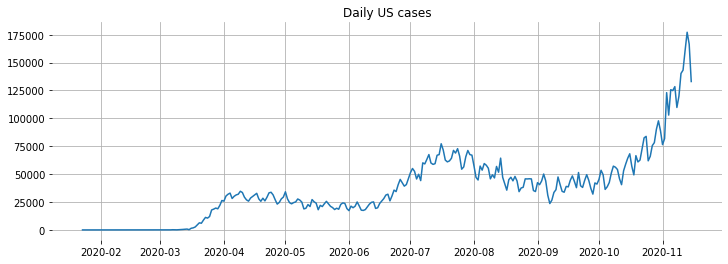

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(dates, cases.sum(axis=1))
ax.set_title('Daily US cases')
ax.grid(True)
ax.set_frame_on(False)

In [4]:
# downsample per week 
X = signal.decimate(cases, 7, axis=0)*7
t = dates[3::7]

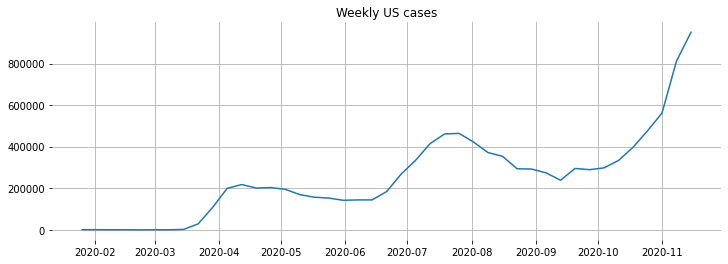

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(t, X.sum(axis=1))
ax.set_title('Weekly US cases')
ax.grid(True)
ax.set_frame_on(False)

In [6]:
# average by state
from collections import defaultdict
totals = defaultdict(int)
for s, x in zip(states, X.T):
    totals[s] = totals[s] + x

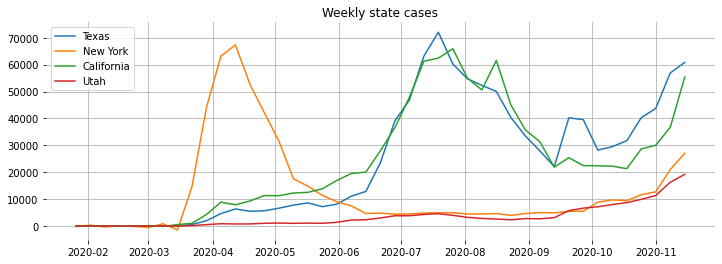

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
select = ('Texas', 'New York', 'California', 'Utah')
for state in select:
    ax.plot(t, totals[state])
ax.set_title('Weekly state cases')
ax.legend(select)
ax.set_frame_on(False)
ax.grid(True)


# PCA by SVD

Singular value decomposition decomposes rectangular matrix $X$ into three components.

$$X = U D V^T$$

where $U$ and $V$ are orthonormal, so that $U^TU=I$ and $V^TV=I$ and $D$ is diagonal with descending positive magnitudes (singular values).

This is a very useful decomposition that simplifies many matrix operations. 

$X$ has dimensions $\text{states} \times \text{weeks}$.

Therefore, $U^T X$ will contain the principal components, ordered by significance, in the space of weeks, and $X V$ will contain the principal components in the space of states. 

Dimensionality reduction is achieved by plotting the first few of these principal components.

In [8]:
# perform singular value decomposition
X = np.array(list(totals.values()))
# a rule for scaling states by size to make smaller states more significant
X /= np.sqrt(100 + X.sum(axis=-1, keepdims=True))  
U, D, V = np.linalg.svd(X, full_matrices=False)
V = V.T  # since svd returns the transpose

# Principal components in time

We plot the first few columns of $U^T X$, which will have the dimension of time. This shows the few modes of evolution of Covid infections across all states. In each state, the pandemic developed as a weighted some of these components.

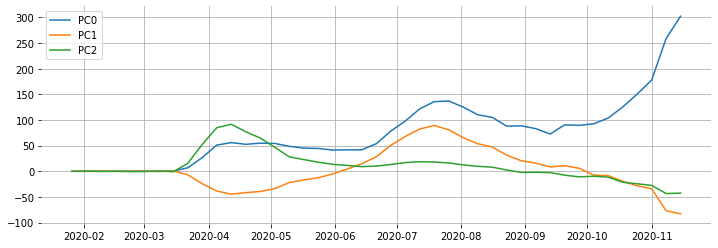

In [9]:
# plot first 3 principal comonents for time:
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(t, (U.T @ X)[:3, :].T)
ax.grid(True)
ax.set_frame_on(False)
ax.legend(("PC0", "PC1", "PC2", "PC3"))

# Principal components across states

Then we plot the first few columns of $X V$, which will have the dimension of states. This shows how states cluster in the space defined by the temporal principal components above. States that are close together followed a similar evolution infection rates.

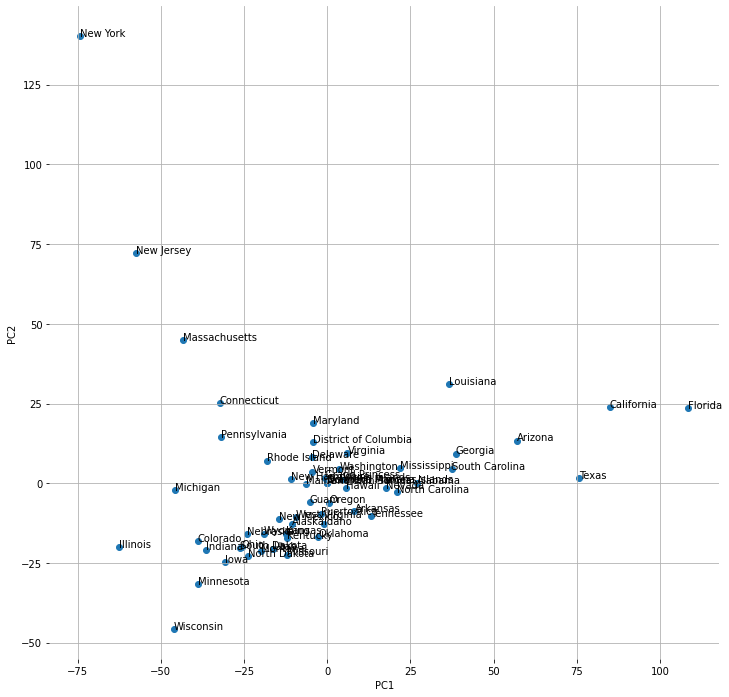

In [10]:
# plot states on principle components
c1, c2 = 1, 2
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
W = U @ np.diag(D)
ax.scatter(W[:, c1], W[:, c2])
for i, (name, u) in enumerate(zip(totals, W)):
    ax.annotate(name, (u[c1], u[c2]))
ax.grid(True)
ax.set_xlabel(f"PC{c1}")
ax.set_ylabel(f"PC{c2}")
ax.set_frame_on(False)
